# Detection of Illicit Bitcoin Transaction

The rise of cryptocurrency leads to new opportunities for illicit activities, such as money laundering, terrorism financing, ransomware attacks, etc.  Identifying such fraudulent transactions then becomes essential. With the nature of blockchain technology, Bitcoin transactions can be represented as a graph. 

We try to propose an approach to detect illicit Bitcoin transactions with the help of graph analysis, visualization skills and machine learning methods we’ve learned in class. We first try to apply traditional machine learning methods, such as logistic regression and boosting, on the graph data. Then, we experiment with Neural Net and use GNN to see if graph neural network can bring improvement to our detection model. Finally, we formulate our problem as an anomaly detection problem to incorporate unlabeled data in our study.

In case the file is not displayed correctly, here is the link to our Colab notebook: https://colab.research.google.com/drive/1VG271SJnkksnbU7UzDkM1hAgAfqvblmd?usp=sharing.

# Data loading

We are using 3 csv files: `elliptic_txs_classes.csv`, `elliptic_txs_edgelist.csv` and `elliptic_txs_features.csv` from [this Kaggle](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) dataset. 
Pleas go to the Kaggle link and create an account, go to Account, click on Create New API Token to get the API key in the form of a json file kaggle.json.

In [ ]:
! pip install pyvis

  Created wheel for pyvis: filename=pyvis-0.2.0-py3-none-any.whl size=23677 sha256=99a589dc524644b113ab88b82f18cbb01cff855f008acfcbb4d34f3aff3b6b3f
  Stored in directory: /root/.cache/pip/wheels/74/ed/a1/9441bf0a9e35efc8351ea92cb62c71c2a604a027b890f970c4
Successfully built pyvis


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML

In [ ]:
!pip install kaggle

Upload the ```kaggle.json``` file to content

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d ellipticco/elliptic-data-set


 92% 135M/146M [00:01<00:00, 114MB/s]
100% 146M/146M [00:01<00:00, 119MB/s]


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/elliptic-data-set.zip

Archive:  /content/elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [ ]:
# Read the csv files and save it to a dataframe
classes_df = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
edgelist_df = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
features_df = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv')

# Data Cleaning

Due to intellectual property issues, no exact description of features in the dataset is provided. 

There is a time step associated to each node(from 1 to 49), representing a measure of the time when a transaction was broadcasted to the Bitcoin network. 

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

In [ ]:
features_df.head(5)

,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,...,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


Therefore, we rename the colomns:

In [ ]:
features_df.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
features_df.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


Then, we construct the final dataset:
1. Join feature dataset with class dataset by txId.
2. Drop colomns time and txId since they are useless for learning.
3. Retrieve only data with known classes and replace class=2 with class=0, making sure that all classes are 0 or 1.

In [ ]:
data = pd.merge(features_df, classes_df, left_on='id', right_on='txId', how='left')

In [ ]:
data = data.drop(['time', 'txId'], axis = 1)
data = data[data['class'] != 'unknown']
data['class'].replace({"1": "1"}, inplace=True)
data['class'].replace({"2": "0"}, inplace=True)
data['class'] = pd.to_numeric(data['class'])

# EDA
First, let's look at the data! This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.

The graph is made of 203,769 nodes and 234,355 edges. Information of nodes is stored in `classes_df`, which contains the ID and class of each node. Information of edges is stored in `edgelist_df`, which contains the source node ID and destination node ID of each edge. There are no null values in both datasets.

In [ ]:
classes_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
edgelist_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


`features_df` contains the features of each trasaction at a specific time step

In [ ]:
features_df.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203768 entries, 0 to 203767
Data columns (total 167 columns):
 #    Column         Dtype  
---   ------         -----  
 0    id             int64  
 1    time           int64  
 2    trans_feat_0   float64
 3    trans_feat_1   float64
 4    trans_feat_2   float64
 5    trans_feat_3   float64
 6    trans_feat_4   float64
 7    trans_feat_5   float64
 8    trans_feat_6   float64
 9    trans_feat_7   float64
 10   trans_feat_8   float64
 11   trans_feat_9   float64
 12   trans_feat_10  float64
 13   trans_feat_11  float64
 14   trans_feat_12  float64
 15   trans_feat_13  float64
 16   trans_feat_14  float64
 17   trans_feat_15  float64
 18   trans_feat_16  float64
 19   trans_feat_17  float64
 20   trans_feat_18  float64
 21   trans_feat_19  float64
 22   trans_feat_20  float64
 23   trans_feat_21  float64
 24   trans_feat_22  float64
 25   trans_feat_23  float64
 26   trans_feat_24  float64
 27   trans_feat_25  float64
 28   trans_feat_2

Although the features are anonymous, we can still analyse the correlation of features from the heatmap.

In [ ]:
corr = features_df.corr()

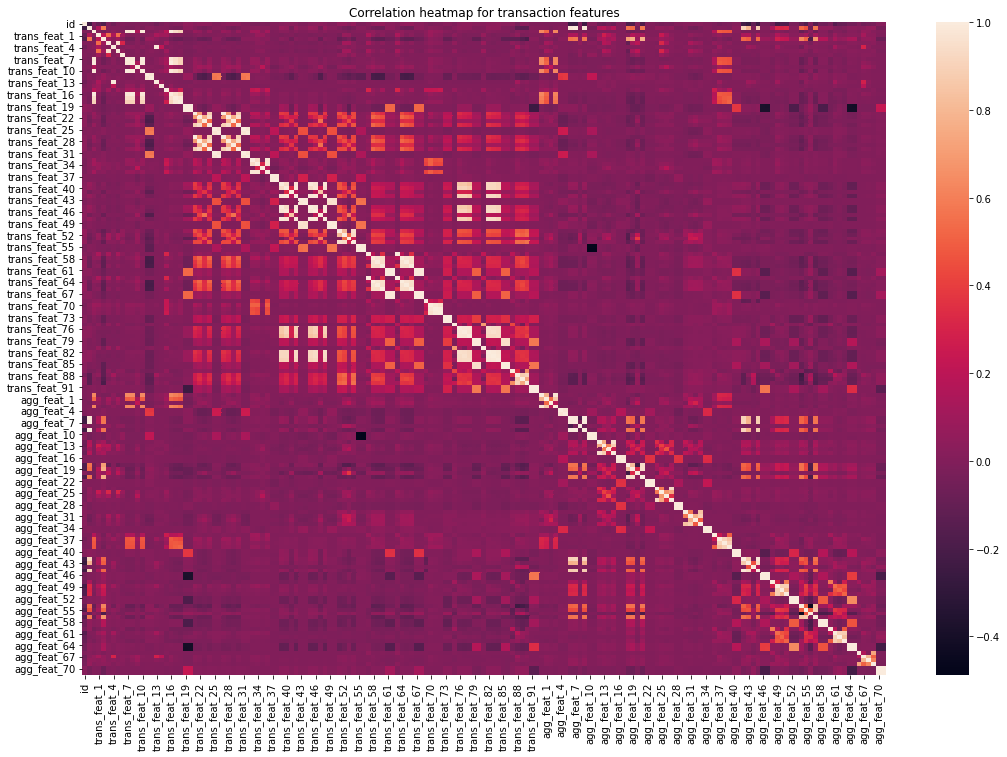

In [ ]:
plt.figure(figsize=(18, 12))
ax = sns.heatmap(corr)
plt.title('Correlation heatmap for transaction features');

We can see from the heatmap that there are some strong correlations between the local features(trans_feat) and some strong correlations between aggregated features(agg_feat), which makes sense since some features are the aggregated figures such as the average of other features. 

There are also some local features negatively correlated with some aggregated features, for example agg_feature46 and trans_feat19.

## Number of transactions per class

In [ ]:
group_class = classes_df.groupby('class').count().reset_index().rename(columns={'txId':'number_of_transactions'})

In [ ]:
group_class

,class,number_of_transactions
0,1,4545
1,2,42019
2,unknown,157205


Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

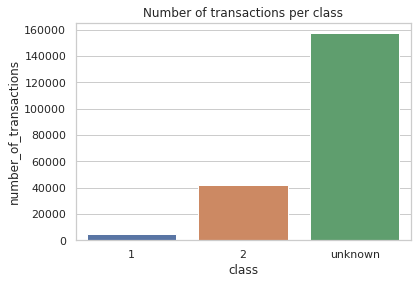

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='class', y='number_of_transactions',data=group_class)
plt.title('Number of transactions per class');

## Number of transactions per time step per class

In [ ]:
feature_class=classes_df.merge(features_df, how='inner', left_on='txId', right_on='id')
feature_class=feature_class[['txId', 'time', 'class']]
feature_class_group=feature_class.groupby(['time','class']).count().reset_index().rename(columns={'txId':'number_of_transactions'})

In [ ]:
feature_class_group.head()

,time,class,number_of_transactions
0,1,1,17
1,1,2,2130
2,1,unknown,5732
3,2,1,18
4,2,2,1099


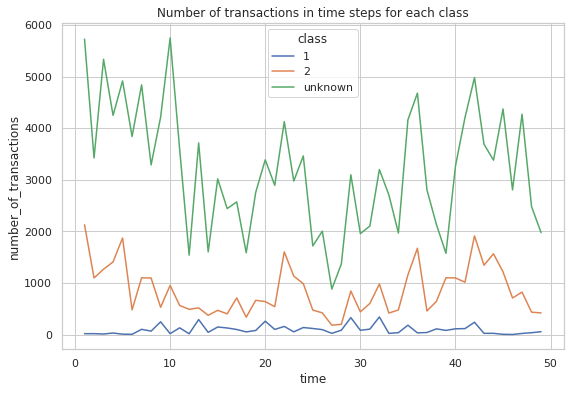

In [ ]:
plt.figure(figsize=(9, 6))
sns.lineplot(x='time', y='number_of_transactions', hue='class', data=feature_class_group);
plt.title('Number of transactions in time steps for each class');

We can see that the number of transations is pretty volatile. But spikes in illicit transactions usually appear when there is a general increase on number of transactions.

## Graph visualization

First, let's get a general idea of licit and ilicit transactions and bitcoin flows by looking at the graph at time step 32.

### transactions at time step 32

* blue: unknown transactions

* yellow: licit transactions

* red: ilicit transactions

(or move cursor on the node to see its class)

In [ ]:
ids = feature_class.loc[(feature_class['time'] == 32), 'txId']
edges = edgelist_df.loc[edgelist_df['txId1'].isin(ids)].merge(classes_df, how='left', left_on='txId1', right_on='txId')[['txId1','txId2','class']].merge(classes_df, how='left', left_on='txId2', right_on='txId')[['txId1','txId2','class_x','class_y']].to_numpy()

net=Network(notebook=True)

for src, dst, color_src, color_dst in edges:
    #add nodes and edges to the graph
    #add source
    if color_src == '1': #ilicit
        net.add_node(src, title='ilicit', color=1)
    if color_src == '2': #licit
        net.add_node(src, title='licit', group=2)
    if color_src == 'unknown': #unknown
        net.add_node(src, title='unknown', group=3)
    #add destination
    if color_dst == '1': #ilicit
        net.add_node(dst, title='ilicit', group=1)
    if color_dst == '2': #licit
        net.add_node(dst, title='licit', group=2)
    if color_dst == 'unknown': #unknown
        net.add_node(dst, title='unknown', group=3)
    # add edge
    net.add_edge(src, dst)


# net.from_nx(graph)
net.show('graph.html')
display(HTML('graph.html'))

As we can see from the graph, the class of most of the transactions are unknown. To get a clearer view, we look at edges with licit source node and ilicit source node separetly:

### Ilicit transactions at time step 32

* blue: ilicit transactions

* yellow: licit transactions

* red: unknown transactions

(or move cursor on the node to see its class)

In [ ]:
ilicit_ids = feature_class.loc[(feature_class['time'] == 32) & (feature_class['class'] == '1'), 'txId']
ilicit_edges = edgelist_df.loc[edgelist_df['txId1'].isin(ilicit_ids)].merge(classes_df, how='left', left_on='txId2', right_on='txId')[['txId1','txId2','class']].to_numpy()

net=Network(notebook=True)

for src, dst, color in ilicit_edges:
    #add nodes and edges to the graph
    #add destination
    if color == '1': #ilicit
        net.add_node(dst, title='ilicit', group=1)
    if color == '2': #licit
        net.add_node(dst, title='licit', group=2)
    if color == 'unknown': #unknown
        net.add_node(dst, title='unknown', group=3)
    #add source
    net.add_node(src, title='ilicit', group=1)
    # add edge
    net.add_edge(src, dst)


# net.from_nx(graph)
net.show('ilicit.html')
display(HTML('ilicit.html'))

We can see from the graph that most ilicit nodes are either clustered or chained. Ilicit transactions mostly have bitcoin flows between each other but flows also exist between licit and ilicit transactions.

### Licit transactions at time step 32

* blue: licit transactions

* yellow: unknown transactions

* red: ilicit transactions

(or move the cursor on the node to see its class)

In [ ]:
licit_ids = feature_class.loc[(feature_class['time'] == 32) & (feature_class['class'] == '2'), 'txId']
licit_edges = edgelist_df.loc[edgelist_df['txId1'].isin(licit_ids)].merge(classes_df, how='left', left_on='txId2', right_on='txId')[['txId1','txId2','class']].to_numpy()

net=Network(notebook=True)

for src, dst, color in licit_edges:
    #add nodes and edges to the graph
    #add destination
    if color == '1': #ilicit
        net.add_node(dst, title='ilicit', group=1)
    if color == '2': #licit
        net.add_node(dst, title='licit', group=2)
    if color == 'unknown': #unknown
        net.add_node(dst, title='unknown', group=3)
    #add source
    net.add_node(src, title='licit', group=2)
    # add edge
    net.add_edge(src, dst)


# net.from_nx(graph)
net.show('licit.html')
display(HTML('licit.html'))

As we can see from the graph that most licit transactions are also clustered. Most bitcoin flows are between licit transactions but there exists some bitcoin flows between licit and ilicit transactions. Moreover, there can be flows between multiple licit transactions and one ilicit transaction.

# Evaluation Function

Since our dataset is imbalanced, we propose the following metrics for a more thorough comparision: accuracy, sensitivity, specificity, ROC_AUC, and F1 score. We hope that not only will we have a good accuracy, but we will also have a good F1 score as well.

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score, accuracy_score,confusion_matrix, precision_score, recall_score, average_precision_score, roc_auc_score,fbeta_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve, roc_curve, plot_roc_curve


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
def print_eval(real_y, pred_y, prob_y):
  cnf_matrix = metrics.confusion_matrix(real_y, pred_y)
  total1=sum(sum(cnf_matrix))
  
  accuracy1=(cnf_matrix[0,0]+cnf_matrix[1,1])/total1
  print ('Accuracy : {0:0.4f}'.format(accuracy1))
  
  sensitivity1 = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
  print('Sensitivity : {0:0.4f}'.format(sensitivity1))
  
  specificity1 = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
  print('Specificity : {0:0.4f}'.format(specificity1))
  
  ROC_AUC=roc_auc_score(real_y, prob_y)
  print('ROC_AUC: {0:0.4f}'.format(ROC_AUC))
  
  F1=f1_score(real_y, pred_y, average=None)
  print('F1_score: {0:0.4f}'.format(F1[1]))


# Imbalanced data handling

Since data is highly imbalance, which may affect the performance of our models. First, we apply SMOTE to handle imbalanced data and see if it improves the performance.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


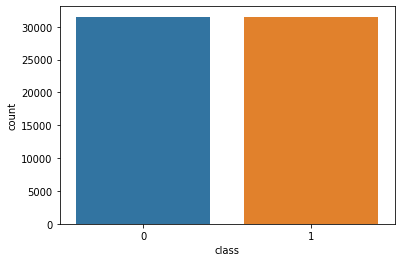

In [ ]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE
#Oversampling the data
smote = SMOTE(random_state = 2022)
X = data.drop(['id', 'class'], axis = 1)
y = data[['class']]
y['class']=pd.to_numeric(y['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 2022)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#Creating a new Oversampling Data Frame
sns.countplot(x="class",data = y_train_smote)

# Logistic Regression

Logistic Regression is a simple maching learning method for binary classification, which suits our objective. We use it as a baseline to provide a point of reference when comparing with other machine learning algorithms.

## Data Preprocessing
Prepare the traning and test data for logistic regression: drop the irrelevant column 'id', and the target column 'class'.

In [ ]:
lr_x = data.drop(['id', 'class'], axis = 1)
lr_y = data['class']

## Train/Test Data Spliting


75% of the data will be used for training, 25% of the data will be used for testing. Set the random_state to be 2022 to ensure reproducibility.

In [ ]:
train_x_lr, val_x_lr, train_y_lr, val_y_lr = train_test_split(lr_x, lr_y, test_size=0.25, random_state = 2022)

## Logistic Regression Training
We use grid search to tune the hyperparameters for the logistic regression model. 
* We try different sets of C, which is the inverse of regularization. The larger the C is, the smaller is the regularization, and our model is more prone to overfitting the data. 
* We also try various types of regularization: L1, L2, and the combination of L1 & L2.
* We experiment with different types of solver: 'lbfgs' and 'liblinear'. Note that the solvers might only support limited types of regulerization. For instance, 'lbfgs' only supports L2 regularization, while 'liblinear' supports L1, L2, and elastic net regularization.

In [ ]:
# defining parameter range
param_grid = {'C':[100, 10, 1.0, 0.1],'penalty':['l1','l2', 'elasticnet'],'solver': ['lbfgs', 'liblinear'], 'random_state': [0]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=4000), param_grid, refit = True)

In [ ]:
 # fitting the model for grid search
grid_lr.fit(train_x_lr,train_y_lr)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

GridSearchCV(estimator=LogisticRegression(max_iter=4000),
             param_grid={'C': [100, 10, 1.0, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [0],
                         'solver': ['lbfgs', 'liblinear']})

In [ ]:
# print best parameter after tuning
print('The best set of parameters after tuning:', grid_lr.best_params_)
# print how our model looks after hyper-parameter tuning
print('The best estimator after tuning:', grid_lr.best_estimator_)
print('The average of r2 scores on left-out test folds for the best parameter combination:', grid_lr.best_score_)

The best set of parameters after tuning: {'C': 100, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs'}
The best estimator after tuning: LogisticRegression(C=100, max_iter=4000, random_state=0)
The average of r2 scores on left-out test folds for the best parameter combination: 0.9729404934973569


In [ ]:
pred_y_lr = grid_lr.best_estimator_.predict(val_x_lr)
yhat_lr = grid_lr.best_estimator_.predict_proba(val_x_lr)

In [ ]:
print_eval(val_y_lr, pred_y_lr, yhat_lr[:, 1])

Accuracy : 0.9761
Sensitivity : 0.9949
Specificity : 0.8056
ROC_AUC: 0.9806
F1_score: 0.8697


# Logistic Regression - after SMOTE

Here, we use logistic regression on balanced data to see if SMOTE improves model performance. Again, we use grid search to find the best parameters.

In [ ]:
# defining parameter range
param_grid = {'C':[100, 10, 1.0, 0.1],'penalty':['l1','l2', 'elasticnet'],'solver': ['lbfgs', 'liblinear'], 'random_state': [0]}
grid_smote = GridSearchCV(LogisticRegression(max_iter=4000), param_grid, refit = True)

 # fitting the model for grid search
grid_smote.fit(X_train_smote,np.ravel(y_train_smote))

# print best parameter after tuning
print('The best set of parameters after tuning:', grid_smote.best_params_)
# print how our model looks after hyper-parameter tuning
print('The best estimator after tuning:', grid_smote.best_estimator_)
print('The average of r2 scores on left-out test folds for the best parameter combination:', grid_smote.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the followin

The best set of parameters after tuning: {'C': 100, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs'}
The best estimator after tuning: LogisticRegression(C=100, max_iter=4000, random_state=0)
The average of r2 scores on left-out test folds for the best parameter combination: 0.9360450364732001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
pred_y_smote = grid_smote.best_estimator_.predict(X_test)
yhat_smote = grid_smote.best_estimator_.predict_proba(X_test)

print_eval(y_test, pred_y_smote, yhat_smote[:, 1])

Accuracy : 0.9298
Sensitivity : 0.9303
Specificity : 0.9253
ROC_AUC: 0.9812
F1_score: 0.7230


We noticed that other than Sensitivity and ROC_AUC, all the other metrics dropped, which means that SMOTE has not improved the performance.

# XGBoost
The results of logistic regression are not bad. However, we want to try some non-linear models to see if there are any improvements. We first try the ensemble method since it does not overfit and usually performs well on the unforeseen dataset. We decide to use XGBoost, which is a fast implementation of gradient tree boosting. The model has an overall good performance in speed
and it can prevent overfitting by pruning.

In [ ]:
from xgboost import XGBClassifier

## Data Preprocessing 

Columns except for 'id' and 'class' are features (xgb_x), and 'class' column is the column for corresponding labels (xgb_y).



In [ ]:
xgb_x = data.drop(['id', 'class'], axis = 1)
xgb_y = data['class']


## Train/Test Data Splitting

75% of the data will be used for training, 25% of the data will be used for testing.



In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb =  train_test_split(xgb_x, xgb_y, test_size=0.25, random_state = 2022)

## XGBoost Training
We used the grid search to find the best parameters for XGBoost model.


We tuned some parameters for the tree booster such
as max depth, n estimators and colsample bytree to control
over-fitting. We also tuned the learning rate for faster
training performance. Below are parameters we used for grid search:

*   max depth : [3, 6]

*   learning rate : [0.01, 0.05, 0.1]

*   n estimators : [100, 500]

*   colsample bytree : [0.3, 0.7]

In [ ]:
# XGBoost
# defining parameter range
param_grid = {'max_depth': [3,6],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 500],
              'colsample_bytree': [0.3, 0.7]
              }
grid_xgb = GridSearchCV(XGBClassifier(random_state = 42), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_xgb.fit(X_train_xgb, y_train_xgb.values.ravel())

# print best parameter after tuning
print(grid_xgb.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_xgb.best_estimator_)

print(grid_xgb.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.971 total time=   6.7s
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.974 total time=   5.7s
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.971 total time=   6.8s
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.975 total time=   5.8s
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.964 total time=   5.8s
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.978 total time=  28.6s
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.977 total time=  28.0s
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.975 total time=  

## XGBoost Model Evaluation
After the grid search, we found the best parameters for XGBoost were:
*   max depth : 6

*   learning rate : 0.1

*   n estimators : 500

*   colsample bytree : 0.7

Then we used these parameters to evaluate the model performance on the test data and plot the ROC curve.

Accuracy : 0.9915
Sensitivity : 0.9989
Specificity : 0.9245
ROC_AUC: 0.9982
F1_score: 0.9556


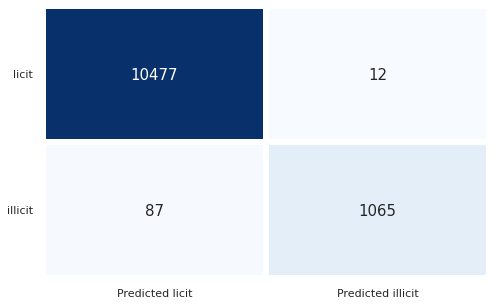

In [ ]:
#Fitting XGBClassifier Model
best_XGB = XGBClassifier(colsample_bytree = 0.7, max_depth = 6, n_estimators = 500, learning_rate= 0.1, random_state=2022)
best_XGB.fit(X_train_xgb, y_train_xgb.values.ravel())
y_pred_xgb = best_XGB.predict(X_test_xgb)
y_prob_xgb = best_XGB.predict_proba(X_test_xgb)[:,1]
print_eval(y_test_xgb, y_pred_xgb, y_prob_xgb)

# Visualizing Confusion Matrix
cm = confusion_matrix(y_test_xgb, y_pred_xgb)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['licit', 'illicit'], xticklabels = ['Predicted licit', 'Predicted illicit'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate_xgb, true_positive_rate_xgb, thresholds = roc_curve(y_test_xgb, y_prob_xgb)
roc_auc_xgb = auc(false_positive_rate_xgb, true_positive_rate_xgb)


Text(0.5, 0, 'False Positive Rate')

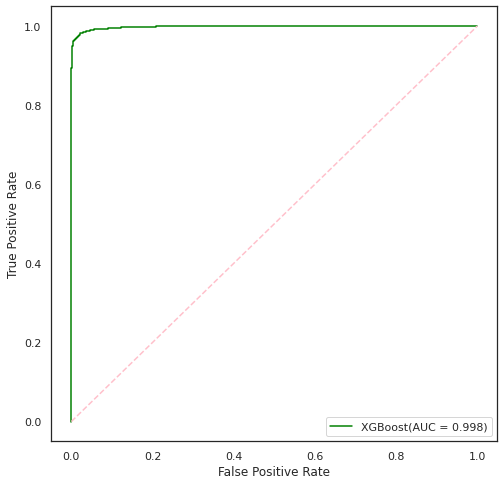

In [ ]:
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate_xgb,true_positive_rate_xgb, color = 'green', label = 'XGBoost(AUC = %0.3f)' % roc_auc_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'pink')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

As we can see XGBoost performs well on our dataset.

# XGBoost - after SMOTE

We try to apply SMOTE for imbalaced data handling. However, the result do not improve much as we expect.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from imblearn.over_sampling import SMOTE

xgb_x = data.drop(['id', 'class'], axis = 1)
xgb_y = data['class']

In [ ]:
X_train_xgb_s, X_test_xgb_smote, y_train_xgb_s, y_test_xgb_smote =  train_test_split(xgb_x, xgb_y, test_size=0.25, random_state = 2022)

In [ ]:
smote = SMOTE(random_state = 2022)
X_train_xgb_smote, y_train_xgb_smote = smote.fit_resample(X_train_xgb_s, y_train_xgb_s)

In [ ]:
# XGBoost
# defining parameter range
param_grid = {'max_depth': [3,6],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 500],
              'colsample_bytree': [0.3, 0.7]
              }
grid_xgb_smote = GridSearchCV(XGBClassifier(random_state = 42), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_xgb_smote.fit(X_train_xgb_smote, y_train_xgb_smote.values.ravel())

# print best parameter after tuning
print(grid_xgb_smote.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_xgb_smote.best_estimator_)

print(grid_xgb_smote.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.927 total time=  12.7s
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.935 total time=  12.4s
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.929 total time=  13.6s
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.935 total time=  13.0s
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.935 total time=  12.3s
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.959 total time= 1.0min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.967 total time=  60.0s
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.966 total time=  

Accuracy : 0.9917
Sensitivity : 0.9977
Specificity : 0.9366
ROC_AUC: 0.9978
F1_score: 0.9570


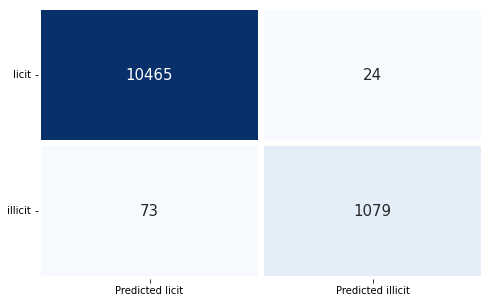

In [ ]:
#Fitting best XGBClassifier Model {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}

best_XGB_smote = XGBClassifier(colsample_bytree = 0.7, max_depth = 6, n_estimators = 500, learning_rate= 0.05, random_state=2022)
best_XGB_smote.fit(X_train_xgb_smote, y_train_xgb_smote.values.ravel())
y_pred_xgb_smote = best_XGB_smote.predict(X_test_xgb_smote)
y_prob_xgb_smote = best_XGB_smote.predict_proba(X_test_xgb_smote)[:,1]
print_eval(y_test_xgb_smote, y_pred_xgb_smote, y_prob_xgb_smote)

# Visualizing Confusion Matrix
cm_xgb_smote = confusion_matrix(y_test_xgb_smote, y_pred_xgb_smote)
plt.figure(figsize = (8, 5))
sns.heatmap(cm_xgb_smote, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['licit', 'illicit'], xticklabels = ['Predicted licit', 'Predicted illicit'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate_xgb_smote, true_positive_rate_xgb_smote, thresholds_xgb_smote = roc_curve(y_test_xgb_smote, y_prob_xgb_smote)
roc_auc_xgb_smote = auc(false_positive_rate_xgb_smote, true_positive_rate_xgb_smote)


Text(0.5, 0, 'False Positive Rate')

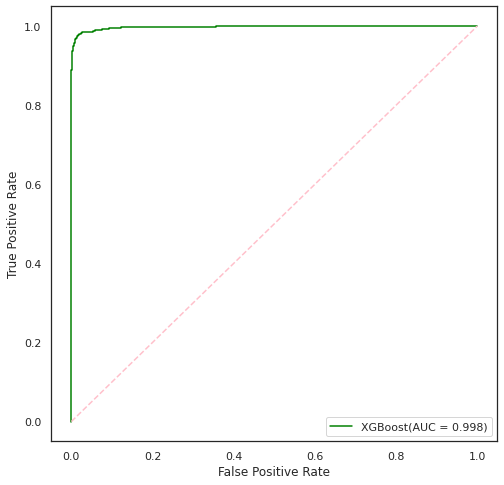

In [ ]:
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate_xgb_smote,true_positive_rate_xgb_smote, color = 'green', label = 'XGBoost(AUC = %0.3f)' % roc_auc_xgb_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'pink')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Feature Importance

We plot the top 10 important features in our XGBoost model.

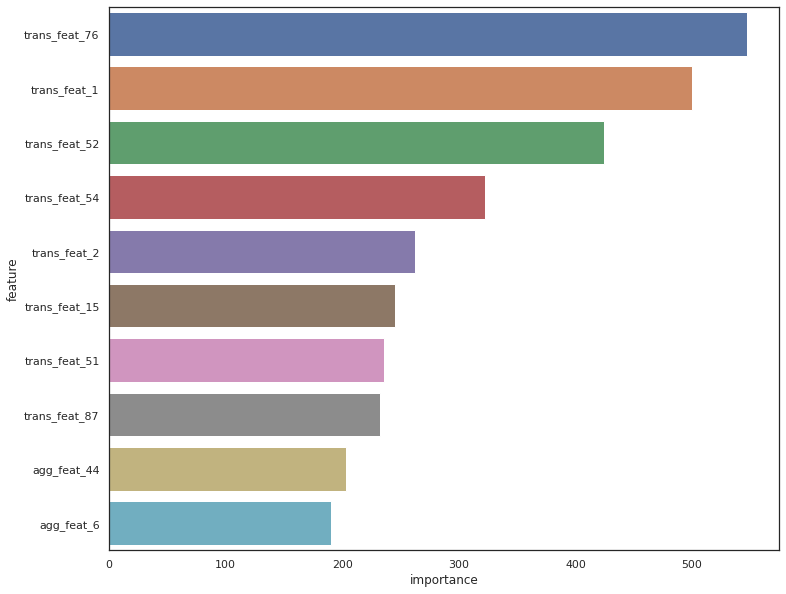

In [ ]:
xgb_fea_imp=pd.DataFrame(list(best_XGB_smote.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)

plt.figure(figsize = (12, 10))
sns.barplot(y="feature", x="importance", data=xgb_fea_imp[:10])

# Neural Net

Since Neural Net is effective in modeling highly volatile data (such as financial time series data) and predicting rare events (such as fraud detection), we want to see how it performs on our dataset. 

## Data Preprocessing
Prepare the traning and test data for neural net: drop the irrelevant column 'id', and the target column 'class'.

In [ ]:
nn_x = data.drop(['id', 'class'], axis = 1)
nn_y = data['class']


## Train/Test Data Splitting

75% of the data will be used for training, 25% of the data will be used for testing.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(nn_x,nn_y,test_size=0.25,random_state=2022)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [ ]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)
y_train_nn = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_test_nn = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())


class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_nn), 
                       torch.FloatTensor(y_train_nn))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test_nn))

## Neural Net Construction

In our neural net, we have 3 linear layers and we use ReLU as our activation function. To reduce the effect of overfitting, we use dropout and batch normalization.

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.01
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(165, 64) 
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.relu(self.linear1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.linear3(x))
        
        return x

## Neural Net Training

In [ ]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,70], gamma=0.1)

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        y_pred_label = torch.round(y_pred)
        correct_results_sum = (y_pred_label == y_batch.unsqueeze(1)).sum().float()
        acc = correct_results_sum/y_batch.unsqueeze(1).shape[0]
        acc = torch.round(acc * 100)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    scheduler.step()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Net(
  (linear1): Linear(in_features=165, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)
Epoch 001: | Loss: 0.68312 | Acc: 94.275
Epoch 002: | Loss: 0.67368 | Acc: 95.659
Epoch 003: | Loss: 0.67251 | Acc: 95.901
Epoch 004: | Loss: 0.67262 | Acc: 95.892
Epoch 005: | Loss: 0.67212 | Acc: 96.073
Epoch 006: | Loss: 0.67233 | Acc: 95.995
Epoch 007: | Loss: 0.67186 | Acc: 96.077
Epoch 008: | Loss: 0.67142 | Acc: 96.099
Epoch 009: | Loss: 0.67169 | Acc: 96.165
Epoch 010: | Loss: 0.67157 | Acc: 96.148
Epoch 011: | Loss: 0.67151 | Acc: 96.143
Epoch 012: | Loss: 0.67135 | Acc: 96.156
Epoch 013: | Loss: 0.67186 | Acc: 

## Neural Net Evaluation

              precision    recall  f1-score   support

           0     0.9677    0.9966    0.9819     10489
           1     0.9571    0.6970    0.8066      1152

    accuracy                         0.9669     11641
   macro avg     0.9624    0.8468    0.8943     11641
weighted avg     0.9666    0.9669    0.9646     11641

ROC AUC score: 0.8211059900054025
Accuracy Score:  0.9669272399278412


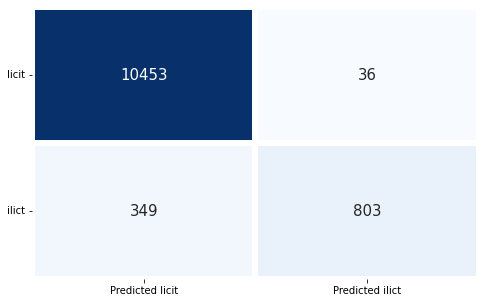

In [ ]:
y_pred_list = []
y_prob = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_prob.append(y_test_pred.cpu().numpy())
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_prob = [a.squeeze().tolist() for a in y_prob]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

cm = confusion_matrix(y_test, y_pred_list)

print(classification_report(y_test, y_pred_list,digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred_list))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['licit', 'ilict'], xticklabels = ['Predicted licit', 'Predicted ilict'])
plt.yticks(rotation = 0)
plt.show()


In [ ]:
print_eval(y_test, y_pred_list, y_prob)

Accuracy : 0.9669
Sensitivity : 0.9966
Specificity : 0.6970
ROC_AUC: 0.8211
F1_score: 0.8066


# Neural Net - after SMOTE

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_smote)
X_test_nn = scaler.transform(X_test)
y_train_nn = torch.squeeze(torch.from_numpy(y_train_smote.to_numpy()).float())
y_test_nn = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())


class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_nn), 
                       torch.FloatTensor(y_train_nn))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test_nn))

In [ ]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,70], gamma=0.1)

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        y_pred_label = torch.round(y_pred)
        correct_results_sum = (y_pred_label == y_batch.unsqueeze(1)).sum().float()
        acc = correct_results_sum/y_batch.unsqueeze(1).shape[0]
        acc = torch.round(acc * 100)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    scheduler.step()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Net(
  (linear1): Linear(in_features=165, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)
Epoch 001: | Loss: 0.68219 | Acc: 94.546
Epoch 002: | Loss: 0.67459 | Acc: 95.480
Epoch 003: | Loss: 0.67235 | Acc: 95.938
Epoch 004: | Loss: 0.67182 | Acc: 96.077
Epoch 005: | Loss: 0.67200 | Acc: 96.027
Epoch 006: | Loss: 0.67202 | Acc: 96.018
Epoch 007: | Loss: 0.67219 | Acc: 95.954
Epoch 008: | Loss: 0.67170 | Acc: 96.150
Epoch 009: | Loss: 0.67210 | Acc: 96.022
Epoch 010: | Loss: 0.67188 | Acc: 96.024
Epoch 011: | Loss: 0.67160 | Acc: 96.093
Epoch 012: | Loss: 0.67222 | Acc: 95.980
Epoch 013: | Loss: 0.67201 | Acc: 

              precision    recall  f1-score   support

           0     0.9682    0.9969    0.9823     10489
           1     0.9619    0.7014    0.8112      1152

    accuracy                         0.9677     11641
   macro avg     0.9650    0.8492    0.8968     11641
weighted avg     0.9675    0.9677    0.9654     11641

ROC AUC score: 0.8770645802216079
Accuracy Score:  0.9677003693840736


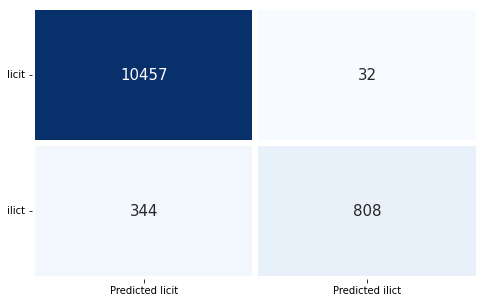

In [ ]:
y_pred_list = []
y_prob = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_prob.append(y_test_pred.cpu().numpy())
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_prob = [a.squeeze().tolist() for a in y_prob]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

cm = confusion_matrix(y_test, y_pred_list)

print(classification_report(y_test, y_pred_list,digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred_list))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['licit', 'ilict'], xticklabels = ['Predicted licit', 'Predicted ilict'])
plt.yticks(rotation = 0)
plt.show()


In [ ]:
print_eval(y_test, y_pred_list, y_prob)

Accuracy : 0.9677
Sensitivity : 0.9969
Specificity : 0.7014
ROC_AUC: 0.8771
F1_score: 0.8112


We noticed that after applying SMOTE, the performance of neural net does not have a significant improvement.

# Graph Neural Networks
The traditional neural network in the last section only uses the information of node features for classification. Since edges might also capture some inner relations between nodes to help classify, we are curious whether Graph Neural Network, which uses both node features and edges, are helpful.

We use the [torch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) package to help us build GNN model.


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 407 kB 5.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=b4821cd94fee335bd16569e0041bbb1f377d45ac8385abf6cfe2f52e04fafb3f
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.nn import GCNConv


##Data Preprocessing

We excluded the node data labeled "unknown", so we first reset the index.

In [ ]:
data_gnn=data.reset_index(drop=True)

For each edge, we converted its node id into the index in the node dataset.

In [ ]:
edge_list = []
for edge in edgelist_df.values.tolist():
  n_from = data_gnn.index[data_gnn['id']==edge[0]].tolist()
  n_to = data_gnn.index[data_gnn['id']==edge[1]].tolist()
  if(len(n_from)>0 and len(n_to)>0):
    edge_list.append([n_from[0],n_to[0]])

We dropped the unnecessary columns for features: 'id' and 'class', and we used 'class' column for labels.

In [ ]:
gnn_x = data_gnn.drop(['id', 'class'], axis = 1)
gnn_y = data_gnn['class']

We transformed the node features, node labels, and edge index list into tensors. Then we constructed the DataLoader used for GNN model.

In [ ]:
node_features=torch.tensor(gnn_x.values.tolist())
node_labels=torch.tensor(gnn_y.values)
edge_index=torch.tensor(edge_list).T
graph_data = Data(x=node_features, y=node_labels, edge_index=edge_index)

## Train/Test Data Spliting
55% of the data will be used for training, 20% of the data will be used for testing, and 25% of the data will be used for testing.

In [ ]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.25)
graph_data=msk(graph_data)
print(graph_data)
print()
print("training samples",torch.sum(graph_data.train_mask).item())
print("validation samples",torch.sum(graph_data.val_mask ).item())
print("test samples",torch.sum(graph_data.test_mask ).item())

Data(x=[46564, 165], edge_index=[2, 36624], y=[46564], train_mask=[46564], val_mask=[46564], test_mask=[46564])

training samples 25610
validation samples 9313
test samples 11641


## GNN Model Construction

The constructor defines two GCNConv layers which get called in the forward pass of our network. The first layer gets the input size equals to number of features. The second layer has output size equal to the number of our classes (2). We chose to use *ReLU* as our activation function. 

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)

    def forward(self, data):
        x = data.x.float()
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

We defined a helper functions to help us calculate the accuracy during each training epoch.

In [ ]:
def masked_accuracy(out,mask,labels):
    pred = out.argmax(dim=1)
    correct = (pred[mask] == labels[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc  

## GNN Training
Now, we define our training function. We keep track for the best validation accuracy and also record losses & accuracies of training/validation set of each epoch. 


In [ ]:
def train_gnn(net,data,optimizer,epochs=10):
    best_accuracy=0.0

    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    net.train()
    for ep in range(epochs+1):
      optimizer.zero_grad()
      out = net(data)

      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      train_losses.append(loss)
      train_acc = masked_accuracy(out,data.train_mask,data.y)
      train_accuracies.append(train_acc)

      val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
      val_losses.append(val_loss)
      val_acc = masked_accuracy(out,data.val_mask,data.y)
      val_accuracies.append(val_acc)

      loss.backward()
      optimizer.step()

      if np.round(val_acc,4)> np.round(best_accuracy ,4):
          print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}"
                    .format(ep+1,epochs, loss.item(), train_acc, val_acc))
          best_accuracy=val_acc
    return train_losses,val_losses,train_accuracies,val_accuracies

We used *Adam* as our optimizer with learning rate of 0.05 and trained the GNN model for 200 epochs.

In [ ]:
num_of_feat=graph_data.num_node_features
net=GNN(num_of_feat=num_of_feat,f=16)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
train_losses,val_losses,train_accuracies,val_accuracies= train_gnn(net,graph_data,optimizer,epochs=200)


Epoch 1/200, Train_Loss: 0.3179, Train_Accuracy: 0.8859, Val_Accuracy: 0.8861
Epoch 3/200, Train_Loss: 0.2949, Train_Accuracy: 0.9212, Val_Accuracy: 0.9188
Epoch 4/200, Train_Loss: 0.2847, Train_Accuracy: 0.9173, Val_Accuracy: 0.9204
Epoch 5/200, Train_Loss: 0.2505, Train_Accuracy: 0.9287, Val_Accuracy: 0.9315
Epoch 6/200, Train_Loss: 0.2171, Train_Accuracy: 0.9380, Val_Accuracy: 0.9400
Epoch 7/200, Train_Loss: 0.1995, Train_Accuracy: 0.9399, Val_Accuracy: 0.9411
Epoch 9/200, Train_Loss: 0.1910, Train_Accuracy: 0.9411, Val_Accuracy: 0.9437
Epoch 10/200, Train_Loss: 0.1857, Train_Accuracy: 0.9435, Val_Accuracy: 0.9459
Epoch 11/200, Train_Loss: 0.1781, Train_Accuracy: 0.9458, Val_Accuracy: 0.9466
Epoch 16/200, Train_Loss: 0.1572, Train_Accuracy: 0.9478, Val_Accuracy: 0.9484
Epoch 17/200, Train_Loss: 0.1549, Train_Accuracy: 0.9483, Val_Accuracy: 0.9491
Epoch 18/200, Train_Loss: 0.1528, Train_Accuracy: 0.9487, Val_Accuracy: 0.9496
Epoch 21/200, Train_Loss: 0.1458, Train_Accuracy: 0.9494, V

We then plot the losses & accuracies of training/validation set for each training epoch.

In [ ]:
train_losses=[item.detach().numpy() for item in train_losses]
val_losses=[item.detach().numpy() for item in val_losses]

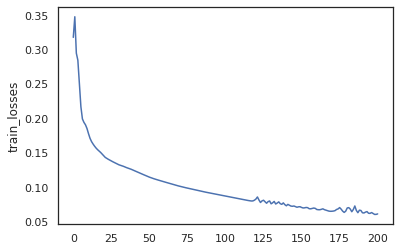

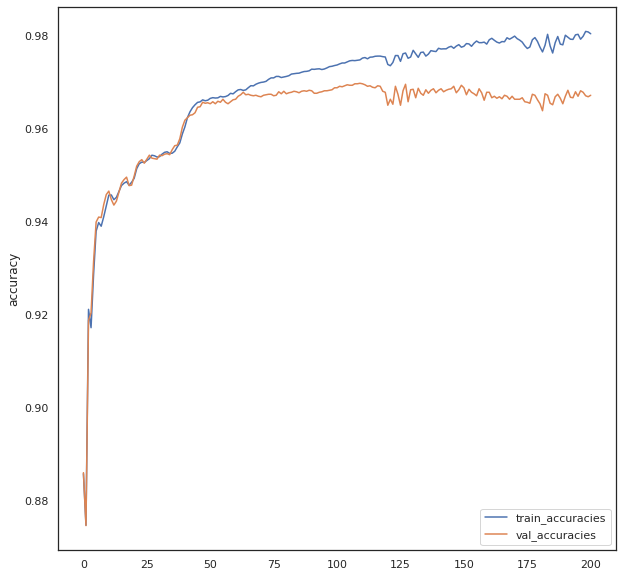

In [ ]:
plt.plot(train_losses) 
plt.ylabel('train_losses')
plt.show()

plt.figure(figsize = (10, 10))
plt.plot(train_accuracies, label = 'train_accuracies') 
plt.plot(val_accuracies, label = 'val_accuracies')
plt.legend(loc = 'lower right')
plt.ylabel('accuracy')
plt.show()

As we can see, the losses are decreasing while the acuracies are increasing.

## GNN Model Evaluation

In [ ]:
y_pred_gnn_list = []
y_prob_gnn = []

net.eval()
y_prob_gnn = net(graph_data)
y_pred_gnn = y_prob_gnn.argmax(dim=1)

y_prob_gnn_test = [item.detach().numpy() for item in y_prob_gnn[graph_data.test_mask]]
y_prob_gnn_test = np.exp(y_prob_gnn_test)[:,1]
y_pred_gnn_test = [item.detach().numpy() for item in y_pred_gnn[graph_data.test_mask]]
y_true = [item.detach().numpy() for item in graph_data.y[graph_data.test_mask]]

print_eval(y_true, y_pred_gnn_test, y_prob_gnn_test)

Accuracy : 0.9656
Sensitivity : 0.9855
Specificity : 0.7809
ROC_AUC: 0.9623
F1_score: 0.8155


Compared to the traditional neural network we use in the previous section, specificity and ROC_AUC increase after we include the edge information using GNN.

# Graph Neural Networks - after SMOTE

We also try to apply SMOTE for imbalaced data handling. We get the results that specificity and ROC_AUC increase a little while accuracy and F1 decrease.

In [ ]:
gnn_x_smote_ori = data.drop(['class'], axis = 1)
gnn_y_smote_ori = data['class']

In [ ]:
X_train_gnn_s, X_test_gnn_smote, y_train_gnn_s, y_test_gnn_smote =  train_test_split(gnn_x_smote_ori, gnn_y_smote_ori, test_size=0.25, random_state = 2022)

In [ ]:
X_train_gnn_s = X_train_gnn_s.reset_index(drop=True)
X_test_gnn_smote = X_test_gnn_smote.reset_index(drop=True)

In [ ]:
edge_list_train = []
for edge in edgelist_df.values.tolist():
  n_from = X_train_gnn_s.index[X_train_gnn_s['id']==edge[0]].tolist()
  n_to = X_train_gnn_s.index[X_train_gnn_s['id']==edge[1]].tolist()
  if(len(n_from)>0 and len(n_to)>0):
    edge_list_train.append([n_from[0],n_to[0]])

In [ ]:
edge_list_test = []
for edge in edgelist_df.values.tolist():
  n_from = X_test_gnn_smote.index[X_test_gnn_smote['id']==edge[0]].tolist()
  n_to = X_test_gnn_smote.index[X_test_gnn_smote['id']==edge[1]].tolist()
  if(len(n_from)>0 and len(n_to)>0):
    edge_list_test.append([n_from[0],n_to[0]])

In [ ]:
X_train_gnn_smote = X_train_gnn_s.drop(['id'], axis = 1)
X_test_gnn_smote = X_test_gnn_smote.drop(['id'], axis = 1)

In [ ]:
smote = SMOTE(random_state = 2022)
gnn_x_smote_train, gnn_y_smote_train = smote.fit_resample(X_train_gnn_smote, y_train_gnn_s)

In [ ]:
node_features_smote_train=torch.tensor(gnn_x_smote_train.values.tolist())
node_labels_smote_train=torch.tensor(gnn_y_smote_train.values)
edge_index_smote_train=torch.tensor(edge_list_train).T
graph_data_smote_train = Data(x=node_features_smote_train, y=node_labels_smote_train, edge_index=edge_index_smote_train)

In [ ]:
node_features_smote_test=torch.tensor(X_test_gnn_smote.values.tolist())
node_labels_smote_test=torch.tensor(y_test_gnn_smote.values)
edge_index_smote_test=torch.tensor(edge_list_test).T
graph_data_smote_test = Data(x=node_features_smote_test, y=node_labels_smote_test, edge_index=edge_index_smote_test)

In [ ]:
msk_train=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0)
graph_data_smote_train=msk_train(graph_data_smote_train)
print(graph_data_smote_train)
print()
print("training samples",torch.sum(graph_data_smote_train.train_mask).item())
print("validation samples",torch.sum(graph_data_smote_train.val_mask ).item())
print("test samples",torch.sum(graph_data_smote_train.test_mask ).item())

Data(x=[63060, 165], edge_index=[2, 20531], y=[63060], train_mask=[63060], val_mask=[63060], test_mask=[63060])

training samples 44142
validation samples 18918
test samples 0


In [ ]:
msk_test=masking(split="train_rest", num_splits = 1, num_val = 0, num_test= 0.99999)
graph_data_smote_test=msk_test(graph_data_smote_test)
print(graph_data_smote_test)
print()
print("training samples",torch.sum(graph_data_smote_test.train_mask).item())
print("validation samples",torch.sum(graph_data_smote_test.val_mask ).item())
print("test samples",torch.sum(graph_data_smote_test.test_mask ).item())

Data(x=[11641, 165], edge_index=[2, 2297], y=[11641], train_mask=[11641], val_mask=[11641], test_mask=[11641])

training samples 0
validation samples 0
test samples 11641


In [ ]:
num_of_feat=graph_data_smote_train.num_node_features
net_smote=GNN(num_of_feat=num_of_feat,f=16)
optimizer = torch.optim.Adam(net_smote.parameters(), lr=0.05)
train_losses_smote,val_losses_smote,train_accuracies_smote,val_accuracies_smote= train_gnn(net_smote,graph_data_smote_train,optimizer,epochs=300)


Epoch 1/300, Train_Loss: 0.7967, Train_Accuracy: 0.4677, Val_Accuracy: 0.4755
Epoch 2/300, Train_Loss: 0.6121, Train_Accuracy: 0.7692, Val_Accuracy: 0.7645
Epoch 3/300, Train_Loss: 0.4383, Train_Accuracy: 0.8124, Val_Accuracy: 0.8108
Epoch 4/300, Train_Loss: 0.4065, Train_Accuracy: 0.8663, Val_Accuracy: 0.8665
Epoch 5/300, Train_Loss: 0.4089, Train_Accuracy: 0.8701, Val_Accuracy: 0.8718
Epoch 6/300, Train_Loss: 0.3568, Train_Accuracy: 0.8758, Val_Accuracy: 0.8783
Epoch 9/300, Train_Loss: 0.3046, Train_Accuracy: 0.8819, Val_Accuracy: 0.8818
Epoch 10/300, Train_Loss: 0.2861, Train_Accuracy: 0.8916, Val_Accuracy: 0.8927
Epoch 11/300, Train_Loss: 0.2853, Train_Accuracy: 0.8971, Val_Accuracy: 0.8981
Epoch 12/300, Train_Loss: 0.2774, Train_Accuracy: 0.8989, Val_Accuracy: 0.8998
Epoch 13/300, Train_Loss: 0.2631, Train_Accuracy: 0.8973, Val_Accuracy: 0.9007
Epoch 16/300, Train_Loss: 0.2397, Train_Accuracy: 0.9065, Val_Accuracy: 0.9069
Epoch 17/300, Train_Loss: 0.2361, Train_Accuracy: 0.9115, V

In [ ]:
train_losses_smote=[item.detach().numpy() for item in train_losses_smote]
val_losses_smote=[item.detach().numpy() for item in val_losses_smote]

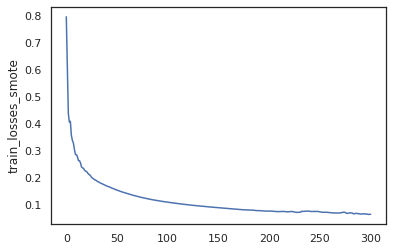

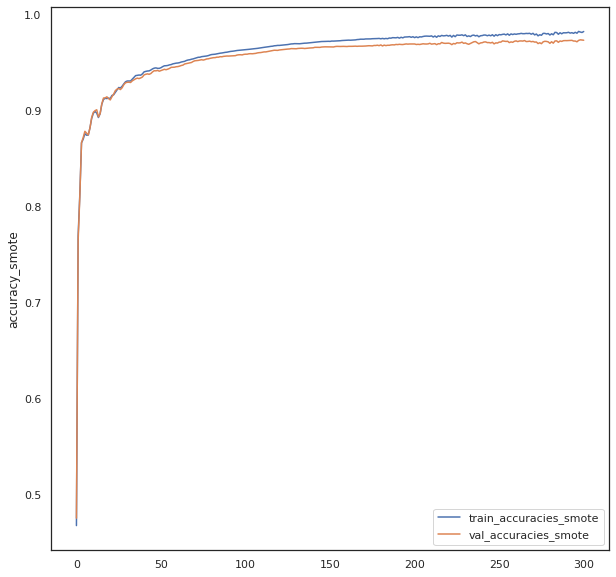

In [ ]:
plt.plot(train_losses_smote) 
plt.ylabel('train_losses_smote')
plt.show()

plt.figure(figsize = (10, 10))
plt.plot(train_accuracies_smote, label = 'train_accuracies_smote') 
plt.plot(val_accuracies_smote, label = 'val_accuracies_smote')
plt.legend(loc = 'lower right')
plt.ylabel('accuracy_smote')
plt.show()

In [ ]:
y_pred_gnn_list_smote = []
y_prob_gnn_smote = []

net_smote.eval()
y_prob_gnn_smote = net_smote(graph_data_smote_test)
y_pred_gnn_smote = y_prob_gnn_smote.argmax(dim=1)

y_prob_gnn_test_smote = [item.detach().numpy() for item in y_prob_gnn_smote[graph_data_smote_test.test_mask]]
y_prob_gnn_test_smote = np.exp(y_prob_gnn_test_smote)[:,1]
y_pred_gnn_test_smote = [item.detach().numpy() for item in y_pred_gnn_smote[graph_data_smote_test.test_mask]]
y_true_smote = [item.detach().numpy() for item in graph_data_smote_test.y[graph_data_smote_test.test_mask]]

print_eval(y_true_smote, y_pred_gnn_test_smote, y_prob_gnn_test_smote)

Accuracy : 0.9522
Sensitivity : 0.9582
Specificity : 0.8976
ROC_AUC: 0.9730
F1_score: 0.7881


As we can see, specificity and ROC_AUC increase a little while accuracy and F1 decrease after SMOTE.

# Anomaly Detection

In this section, we will investigate the data from a different perspective. Instead of formulating an imbalanced binary classification problem, we hope to formulate an anomaly detection problem. Anomaly detection is the process of identifying irregular/abnormal points in data sets that differs significantly from the norm. It has two basic assumptions: anomalies only occur very rarely in the data, and their features differ from the normal instances significantly. Our data fits the description as the fraud transactions will only comprise a very small proportion of all transactions, and it will have some features that significantly differ from the regular transactions.

The main reason we want to formulate an anomaly detection problem is because in reality, most of the transactions will not have labels. Before any loss is generated by fraud transactions and we observe them explicitly, we can only detect/infer fraud transactions based on all the data we have with the assumption that that the majority of them are normal (but we don't know the exact percent). Therefore, although anomaly detection might not generate results that are as good as the binary classification problem, the 'semi-suprevised' nature of it carries great significance in reality.


In [ ]:
# import modules
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import regularizers, layers, losses
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score, accuracy_score,confusion_matrix, precision_score, recall_score, average_precision_score, roc_auc_score,fbeta_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve, roc_curve, plot_roc_curve
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from matplotlib import pyplot
import networkx as nx

##Prepare train and test data

In [ ]:
# create the x and y 
labels = data["class"]
data_ = data.drop(['class', 'id'], axis = 1)
# perform train test split using random state = 2022
train_data, test_data, train_labels, test_labels = train_test_split(data_, labels, test_size=0.25, random_state=2022)

We observe that the proportion of fraud transations is almost the same in both the training and test set, which is around 10%.

In [ ]:
train_labels.value_counts()

0    31530
1     3393
Name: class, dtype: int64

In [ ]:
test_labels.value_counts()

0    10489
1     1152
Name: class, dtype: int64

In [ ]:
# use the minmax scaler to normalize data
scaler = preprocessing.MinMaxScaler()
scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

To train the Encoders, we will only be using the normal data. Therefore, here we further split train and test data based on whether they are normal or anomalous data or not.

In [ ]:
# train the autoencoder using only the normal, which are labeled in this dataset as 0
normal_train_data = train_data[train_labels == 0]
normal_test_data = test_data[test_labels == 0]

anomalous_train_data = train_data[train_labels == 1]
anomalous_test_data = test_data[test_labels == 1]

In [ ]:
train_data.shape

(34923, 165)

In [ ]:
normal_train_data.shape

(31530, 165)

## Visualization via COPOD

First, we want to verify that it is proper to frame our problem as a anomaly detection problem through visualization. With the help of the COPOD (Copula-Based Outlier Detection) algorithm, we could use the copulas function to separate marginal distributions from the dependency structure of our multivariate data distribution, and see if the normal vs. anomalous data do have a significantly different distribution across the entire feature space. COPOD can also help explain which features contribute most to the outlier score.

In [ ]:
!pip install pyod

     |████████████████████████████████| 118 kB 5.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.0-py3-none-any.whl size=144471 sha256=7069960ec84d30ccffee29acf033377a2e5f7b70bd90c97b8873297dbdce54ee
  Stored in directory: /root/.cache/pip/wheels/37/e6/25/8098880dadf78bf063ee9b37477b1a9317e8bb0fc06e623187
Successfully built pyod


In [ ]:
# train_data, test_data, train_labels, test_labels

In [ ]:
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
from pyod.models.copod import COPOD

In [ ]:
# first, we apply PCA to reduce the high dimensionality of our data
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
pca = pca.fit(train_data)
train_data_pca = pca.transform(train_data)
test_data_pca = pca.transform(test_data)

In [ ]:
normal_train_data_pca = pca.transform(normal_train_data)
anomalous_train_data_pca = pca.transform(anomalous_train_data)

In [ ]:
#  training using only the nomal train data
clf_name = 'COPOD'
clf = COPOD(contamination = 0.1)
clf.fit(normal_train_data_pca)
test_scores = clf.decision_function(test_data_pca)
test_scores = np.reciprocal(test_scores)
pred_y = clf.predict(test_data_pca)

The performance of anomaly detection achieved by COPOD is lower than baseline, thus it is not the right approach to solve the problem.

In [ ]:
print_eval(test_labels, pred_y, test_scores)

Accuracy : 0.8039
Sensitivity : 0.8900
Specificity : 0.0200
ROC_AUC: 0.8291
F1_score: 0.0198


However, we do see that our normal data and anomalous data have a very different COPOD decision score. The anomalous data has higher outlier scores than the nomal data across the entire feature space. But we also observe that the normal data and anomalous data have overlapping decision score from [0.03, 0.06], which means that there is a portion of the anomalous data that have very similar features as the normal data. **These data is the pain point of our anomaly detection**, and explains why COPOD is having a hard time distinguishing them.

Text(0.5, 0, 'Decision Score')

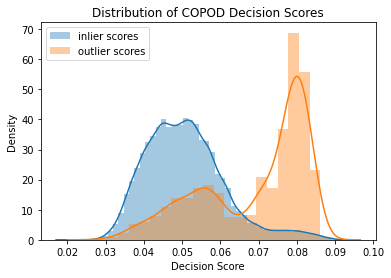

In [ ]:
X = np.concatenate([train_data_pca, test_data_pca], axis=0)
ys = np.concatenate([train_labels, test_labels], axis = 0)

scores = clf.decision_function(X)
scores = np.reciprocal(scores)

sns.distplot(scores[ys==0], label="inlier scores")
sns.distplot(scores[ys==1], label="outlier scores").set_title("Distribution of COPOD Decision Scores")
plt.legend()
plt.xlabel("Decision Score")

We can also see that comparing with the inlier data (for instance, sample #151), the outlier data (sample #626) has significantly larger outlier score in dimension 2 and 9, both of them are higher than the 0.9 cutoff band. If we actually have the name of features, we could use this method to help us find the key features that make anomalous data outliers.

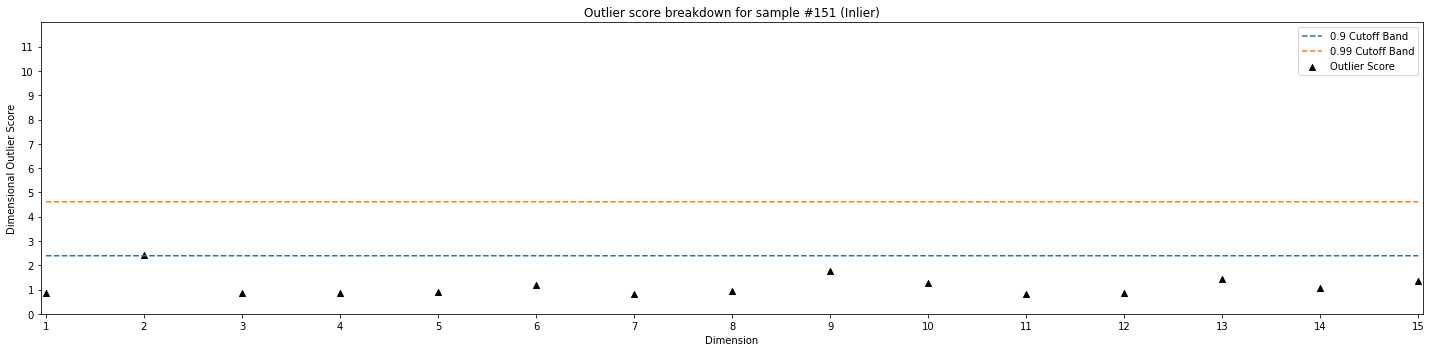

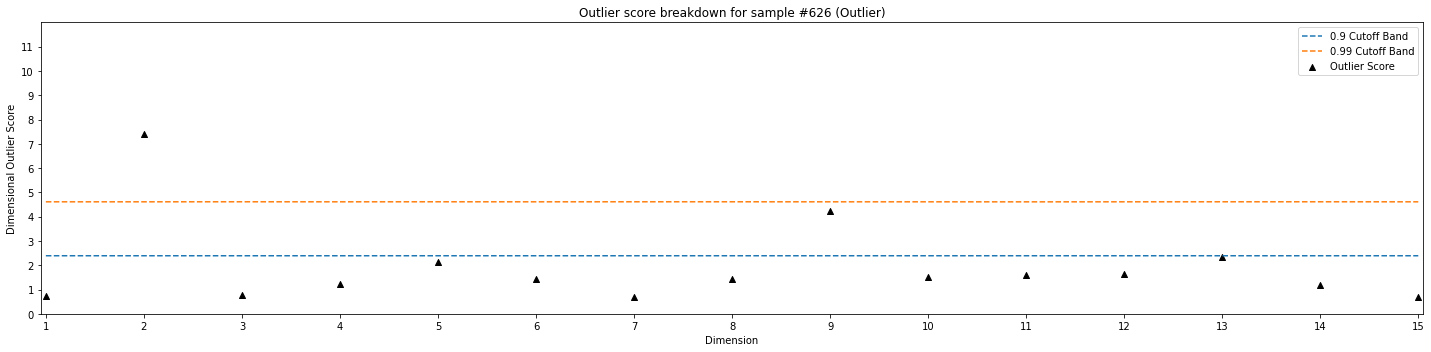

In [ ]:
# DON'T run this cell
# train_outliers_idx = np.where(y_train==1)[0]
train_outliers_idx = [150,625]
for idx in train_outliers_idx:
  plt.figure(figsize=(20,5))
  clf.explain_outlier(idx, cutoffs=None, feature_names=None)

## Building an Autoencoder

The COPOD visualization has shown that the anomalous data is statistically different across several key dimensions. Among the other techniques for anomaly detection, we choose to play with the autoencoder model. It is a generative unsupervised deep learning algorithm that is useful for reconstructing high-dimensional input data. With a neural network that has a narrow bottleneck layer in the middle, autoencoder could find the latent representation of the input data and therefore detect the abnormal data that differs from the normal data in these latent representations.

* During the training, we feed only normal transaction data into the Encoder. The bottleneck layer will learn the latent representation of the normal input that is of much lower dimension than the original data.

* Then, the Decoder will use the bottleneck layers output to reconstruct the normal transactions of the original input data.

* A fraudulent transaction will be different from a normal transaction. 

* The Autoencoder will have trouble reconstructing the fraudulent transaction, and hence the reconstruction error will be high.

* We can flag a new transaction is fraudulent based on a specified threshold value for the reconstruction error.

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(132, activation="tanh"),
      layers.Dense(100, activation="tanh"),
      # layers.Dense(96, activation="relu"),
      layers.Dense(50, activation="tanh")  ##
      # ,layers.Dense(15, activation="tanh")
      # ,layers.Dense(32, activation="tanh")
      # ,layers.Dense(32, activation="relu")  #
      ])

    self.decoder = tf.keras.Sequential([
      # layers.Dense(8, activation="relu"),                        
      # layers.Dense(32, activation="tanh"),  #
      # layers.Dense(16, activation="tanh"),
      layers.Dense(50, activation="tanh"), ##
      # layers.Dense(15, activation="tanh"),
      # layers.Dense(96, activation="tanh"),
      layers.Dense(100, activation="tanh")
      # layers.Dense(165, activation="relu")
      ])
    self.outlayer = tf.keras.Sequential([
       layers.Dense(132, activation="tanh"),
      #  layers.Dense(50, activation="tanh")
      # layers.Dense(150, activation="tanh"),
       layers.Dense(165, activation="relu")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    output = self.outlayer(decoded)
    # return decoded
    return output

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
normal_train_data.shape

(31530, 165)

In [ ]:
# the autoencoder is trained using the normal train data, but is evaluated using the full test set.
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=256,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
124/124 [==============================] - 4s 7ms/step - loss: 0.0932 - val_loss: 0.0580
Epoch 2/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0502 - val_loss: 0.0396
Epoch 3/50
124/124 [==============================] - 1s 5ms/step - loss: 0.0351 - val_loss: 0.0297
Epoch 4/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0298 - val_loss: 0.0276
Epoch 5/50
124/124 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0249
Epoch 6/50
124/124 [==============================] - 0s 4ms/step - loss: 0.0251 - val_loss: 0.0241
Epoch 7/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0235 - val_loss: 0.0238
Epoch 8/50
124/124 [==============================] - 0s 4ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 9/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0215 - val_loss: 0.0214
Epoch 10/50
124/124 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0203

We can see that the training loss and validation loss converge at around 20 epochs.

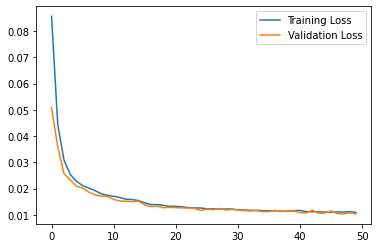

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Plot a normal data sample from the test set, as well as the reconstruction after it has been encoded and decoded by the autoencoder. We see that for this example, the model's reconstruction is slightly off around dimension 120.

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()
decoded_data = autoencoder.outlayer(autoencoder.decoder(encoded_data).numpy()).numpy()

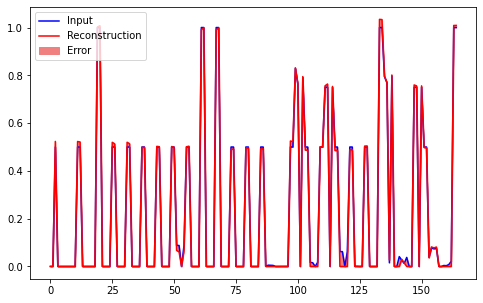

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(normal_test_data[10], 'b')
plt.plot(decoded_data[10], 'r')
plt.fill_between(np.arange(165), decoded_data[10], normal_test_data[10], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Plot a anomalous data sample from the test set, as well as the reconstruction after it has been encoded and decoded by the autoencoder. We see that for this example, the model's reconstruction is off around dimension 100 and 150. Normally we would expect that the reconstruction loss for anomalous data to be higher than the normal data.

In [ ]:
#  for an anomalous test example
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()
decoded_data = autoencoder.outlayer(autoencoder.decoder(encoded_data).numpy()).numpy()

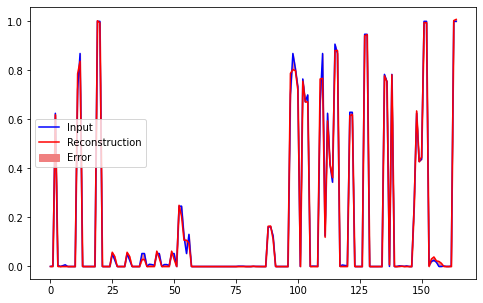

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(anomalous_test_data[20], 'b')
plt.plot(decoded_data[20], 'r')
plt.fill_between(np.arange(165), decoded_data[20], anomalous_test_data[20], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Plot the reconstruction loss of normal data.

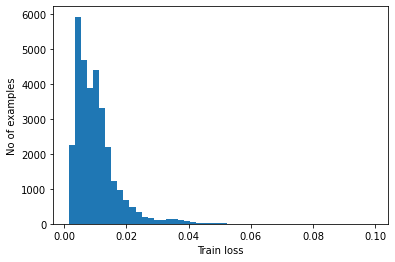

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Use ~1 standard deviation as the threshold.

In [ ]:
threshold = np.mean(train_loss) - 0.85*np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.003773089107098053


Next, we plot the reconstruction loss of the anomalous data. Normally, we would expect that the reconstruction loss of anomalous data to be higher than the normal data. However, we see that somehow our reconstruction loss for the anomalous data is lower than the normal test data. Also, a great portion of it overlap with the reconstruction loss for the normal data. We can confidently categorize those data that have high construction loss to be the normal data, but are uncertain about how to categorize data with low loss.

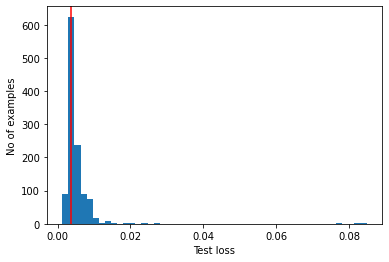

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.axvline(threshold,c='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

We make the prediction with autoencoders. Although the accuracy and ROC_AUC score is much lower than the previous methods, remember that here, we have only trained using the normal data. Namely, the model have not seem any anomalous data during training. Therefore, its performance would be lower. But still, this result is good if we don't have any label available to us and we want to make the prediction in reality. For an imbalanced set with normal:anomalous = 9:1, **the baseline F1 score for the anomalous class is around 0.18, here we achieved 0.33.**

In [ ]:
preds = 1*np.array(predict(autoencoder, test_data, threshold))
print_eval(test_labels.values, preds, preds)

Accuracy : 0.8224
Sensitivity : 0.8647
Specificity : 0.4366
ROC_AUC: 0.6507
F1_score: 0.3273


In [ ]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90     10489
           1       0.26      0.44      0.33      1152

    accuracy                           0.82     11641
   macro avg       0.60      0.65      0.61     11641
weighted avg       0.87      0.82      0.84     11641



## Logistic Regression + Autoencoder

We will also try to use the hidden representation learned by the Autoencoder, and feed them into another logistic regression to make the prediction. Here, autoencoder serves as a dimensionality reduction tool that reduced the number of features from 165 to 50.

In [ ]:
autoencoder.layers

In [ ]:
autoencoder.encoder

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
# hidden_representation.add(autoencoder.layers[3])

In [ ]:
x_normal = data[data['class'] == 0].drop(['id','class'], axis = 1)
x_fraud = data[data['class'] == 1].drop(['id','class'], axis = 1)

In [ ]:
norm_hid_rep = hidden_representation.predict(x_normal)
fraud_hid_rep = hidden_representation.predict(x_fraud)

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

We plot the distribution of hidden representation learned by autoencoders with t-SNE. It maps clusters in high-dimensional data to a two dimensional plane so we see how easy it will be to discriminate between classes.

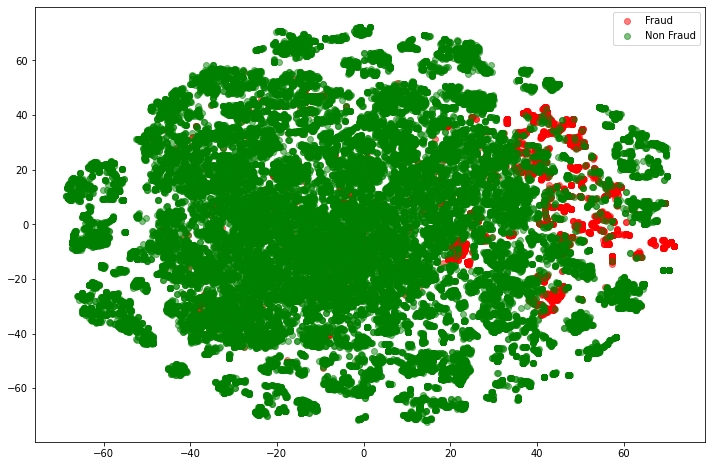

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.5, label='Fraud')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.5, label='Non Fraud')

    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [ ]:
from sklearn.preprocessing import StandardScaler
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state = 2022)

# scaler_1 = preprocessing.MinMaxScaler()
# scaler_1 = StandardScaler()
# scaler_1 = scaler_1.fit(train_x)

# train_x = scaler_1.transform(train_x)
# val_x = scaler_1.transform(val_x)

clf = LogisticRegression(solver="saga",max_iter=4000).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     10490
         1.0       0.89      0.70      0.78      1151

    accuracy                           0.96     11641
   macro avg       0.93      0.84      0.88     11641
weighted avg       0.96      0.96      0.96     11641


Accuracy Score:  0.9613435271883859


## LR + Autoencoder Evaluation

In [ ]:
yhat = clf.predict_proba(val_x)

In [ ]:
#Model Evaluation using Confusion Matrix
cnf_matrix = metrics.confusion_matrix(val_y, pred_y)
cnf_matrix

array([[10390,   100],
       [  350,   801]])

The results of logistic regression after dimentionality reduction through autoencoders seem to be worse than the baseline logistic regression. This means that reducing the feature dimension from 165 to 50 does not remove noise, but rather make us lose useful information.

In [ ]:
total1=sum(sum(cnf_matrix))
accuracy1=(cnf_matrix[0,0]+cnf_matrix[1,1])/total1
print ('Accuracy : {0:0.4f}'.format(accuracy1))

sensitivity1 = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print('Sensitivity : {0:0.4f}'.format(sensitivity1))

specificity1 = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print('Specificity : {0:0.4f}'.format(specificity1))

ROC_AUC = roc_auc_score(val_y, yhat[:, 1])
print('ROC_AUC: {0:0.4f}'.format(ROC_AUC))

F1 = f1_score(val_y,pred_y, average=None)
print('F1_score: {0:0.4f}'.format(F1[1]))

Accuracy : 0.9613
Sensitivity : 0.9905
Specificity : 0.6959
ROC_AUC: 0.9498
F1_score: 0.7807


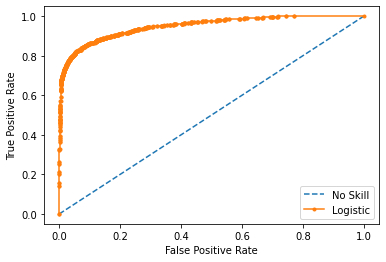

In [ ]:
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(val_y, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

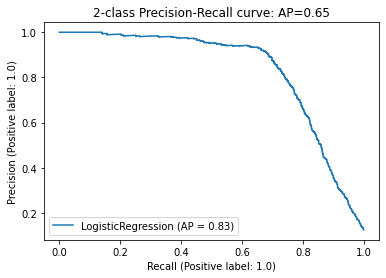

In [ ]:
average_precision = average_precision_score(val_y,yhat[:, 1].round())
disp = plot_precision_recall_curve(clf, val_x, val_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

# Logistic Regression + Autoencoder  - after SMOTE

The result of logistic regression + autoencoder after applying SMOTE to the training data is worse compared to not using SMOTE. This means that oversampling potentially reinforced the exsisting bias in compressing data to lower dimensions, and make the prediction to be less accurate.

In [ ]:
# train_data, test_data, train_labels, test_labels

In [ ]:
from imblearn.over_sampling import SMOTE
#Oversampling the data
smote = SMOTE(random_state = 2022)
train_x_sm, val_x_sm, train_y_sm, val_y_sm = train_test_split(rep_x, rep_y, test_size=0.25, random_state = 2022)
train_x_after_sm, train_y_after_sm = smote.fit_resample(train_x_sm, train_y_sm)

In [ ]:
print('proportion of fraud in train data before SMOTE:', sum(train_y_sm)/len(train_y_sm))

proportion of fraud in train data before SMOTE: 0.0971852360908284


In [ ]:
print('proportion of fraud in train data after SMOTE:', sum(train_y_after_sm)/len(train_y_after_sm))

proportion of fraud in train data after SMOTE: 0.5


In [ ]:
clf_sm = LogisticRegression(solver="saga",max_iter=4000).fit(train_x_after_sm, train_y_after_sm)
pred_y_sm = clf_sm.predict(val_x_sm)

print ("")
print ("Classification Report: ")
print (classification_report(val_y_sm, pred_y_sm))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y_sm, pred_y_sm))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     10490
         1.0       0.45      0.89      0.60      1151

    accuracy                           0.88     11641
   macro avg       0.72      0.88      0.76     11641
weighted avg       0.93      0.88      0.90     11641


Accuracy Score:  0.881625289923546


In [ ]:
yhat_sm = clf_sm.predict_proba(val_x_sm)

In [ ]:
print_eval(val_y_sm, pred_y_sm, yhat_sm[:,1])

Accuracy : 0.8816
Sensitivity : 0.8811
Specificity : 0.8862
ROC_AUC: 0.9549
F1_score: 0.5968


# Summary

* We use Logistic Regression as our baseline. By using GridSearchCV, we find the optimal sets of hyperparameters. The Logistic Regression model with L2 penalty and solver 'lbfgs' gives the best result. The accuracy is 0.97, best ROC_AUC is 0.98, and best F1 score is 0.87. After applying SMOTE, the accuracy drops to 0.93; the F1 score drops to 0.72. But the specificity improves from 0.80 to 0.93. Overall, we would say that SMOTE does not help our model much.
*We then try the ensemble method - XGBoost with grid search to find the best parameters. We get the best accuracy of 0.99, best ROC_AUC of 0.99 and best F1 score of 0.96. We also apply SMOTE to handle imbalanced data. The results after SMOTE do not improve much as we expect. The accuracy, ROC_AUC and F1 score basically remain the same while the specificity is improved by 1%.
*We move on to a different approach - Nerual Net. We get 0.97 for accuracy, 0.82 for ROC_AUC and 0.81 for F1 score. After applying SMOTE, there is no significant improvement on the performance. 
*We also expriment Graph Neural Network which uses both nodes features and edges. Specificity and ROC_AUC are improved compared to the traditional neural network. Since our data is imbalanced, we apply SMOTE and train again. Specificity and ROC_AUC increase a little while accuracy and F1 decrease after SMOTE. The specificity improves from 0.78 to 0.90 and the ROC_AUC score improves from 0.96 to 0.97. However, the best accuracy drops from 0.97 to 0.95 and the best F1 score drops from 0.82 to 0.78. 
* As we try to solve the problem with anomaly detection procedures, we first use COPOD to calculate the outlier scores of anomalous data. Next, we use autoencoder to perform the detection task. Lastly, we feed the hidden representations learned by autoencoders into the logistic regression and apply SMOTE. The best accuracy is 0.96; best ROC_AUC is 0.98; best F1 score is 0.78.

* **Among all the models, XGBoost has the best overall performance. It has both the highest accuracy and F1 score.**

# Challanges and Obstacles faced

* Framing the problem as a anomaly detection problem is not as appropriate as we previously expected. No matter how we tune the structure/hyperparameters, part of the fraud data/hidden representation of fraud data always share similar features with the normal data. Therefore, there is a bottleneck in the performance of autoencoders.
* The performance of our Neural Net is somewhat worse than Logistic Regression, which might be the result of overfitting.
* The specificy increases a little while the accuracy decreases after SMOTE. In other words, applying SMOTE does not necessarily improve the model performance.

# Future Steps

There are a few aspects that this project could further improve if given more time:
* Experiment with VAE or convolutional layers to see if they could find more appropriate hidden representations that distinguish well between fraud and normal data.

* Experiment with different constructions of Neural Net/Graph Neural Networks to see if the performance can be further improved.

* Try other methods to handle the imbalanced data.

* Since our data also have time information, we could impove by including a time series analysis.